<a href="https://colab.research.google.com/github/amhen/ML_perm/blob/main/Binary_GCN_model_abx_perm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
#conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install rdkit-pypi
!pip install --pre deepchem
import deepchem
deepchem.__version__


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3457  100  3457    0     0  37172      0 --:--:-- --:--:-- --:--:-- 37172
/bin/bash: /root/miniconda/bin/conda: No such file or directory
     |████████████████████████████████| 22.7 MB 1.4 MB/s 
     |████████████████████████████████| 608 kB 34.2 MB/s 


'2.6.1'

In [3]:
#creating machine learning df 
import deepchem as dc
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

!pip install wandb --upgrade
import wandb

from deepchem.models.wandblogger import WandbLogger
from deepchem.models.callbacks import ValidationCallback
from rdkit import Chem
from rdkit import RDConfig
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.pipeline import Pipeline
from keras.callbacks import TensorBoard
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
import tempfile
import shutil
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow.keras.layers as layers
from deepchem.feat.mol_graphs import ConvMol
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf

     |████████████████████████████████| 1.8 MB 16.2 MB/s 
     |████████████████████████████████| 181 kB 53.3 MB/s 
     |████████████████████████████████| 144 kB 42.0 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0449d0cae89025bca613cb8cd4930081ae155899d8b1decc01c9a9b594ac910f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# Graph convulutional neural network with a binary output

GCN model was built following DeepChem tutorials:

GCN:
https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Graph_Convolutions.ipynb

Atomic contributions:
https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Atomic_Contributions_for_Molecules.ipynb 



1. dataset file is "mdf2 - mdf2.csv"
  - it contains 748 compounds from SPARK dataset, SMILES, and lables
2. a loader is created that is used to create a dataset file
  - it takes the tasks of the model = the labels (class 0, and class 1)
  - it takes the column to be featurised
  - featurises the column into convolutional molecules
3. A random splitter is initiallised
  - data is split in a 80:10:10 split
  - 80% of data is randomly split into train_dataset
  - 10% of data is split into test_dataset
  - 10% of data is split into valid_dataset 
4. a GCN model is created using DeepChem architecture. 
5. Model is fit on the train dataset over 30 epochs
6. The metrics of the model are assessed based on the models perfomance on the test dataset. 
  - (The validation dataset is typically used for hyperparameter optimisation, but in this instance I have included the scores on the valid_dataset too)
  




In [5]:

featurizer = dc.feat.ConvMolFeaturizer()
from deepchem.utils.save import load_from_disk
dataset_file= "/content/mdf2 - mdf2.csv"
dataset = load_from_disk(dataset_file)


loader = dc.data.CSVLoader(
      tasks=["class_0","class_1"], feature_field="SMILES",
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,seed=3)
transformers = []

tasks=["class_0","class_1"]
model_dir =  "/content/gdrive/My Drive/{dc_gcn_perm_4}"

batch_size = 11

model = dc.models.GraphConvModel(
    len(tasks),
    dropout=0.1,
    batch_size=batch_size,
    batch_normalize=True,
    mode='classification',
    model_dir=model_dir,
    )

metric = dc.metrics.Metric(dc.metrics.roc_auc_score , np.mean,mode='classification')
model.fit(train_dataset, nb_epoch=30)


print('training set score:', model.evaluate(train_dataset, [metric],transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))
print('valid set score:', model.evaluate(valid_dataset, [metric], transformers))


deepchem.utils.save has been deprecated.
The utilities in save.py are moved to deepchem.utils.data_utils or deepchem.utils.genomics_utils.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(76,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(76, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/grap

training set score: {'mean-roc_auc_score': 0.9171617002063983}
test set score: {'mean-roc_auc_score': 0.7527472527472527}
valid set score: {'mean-roc_auc_score': 0.8418209876543209}


In [6]:
print('valid set score:', model.evaluate(valid_dataset, [metric], transformers))

valid set score: {'mean-roc_auc_score': 0.8418209876543209}


# Hyperparameter optimisation

In [7]:

featurizer = dc.feat.ConvMolFeaturizer()
from deepchem.utils.save import load_from_disk
dataset_file= "/content/mdf2 - mdf2.csv"
dataset = load_from_disk(dataset_file)


loader = dc.data.CSVLoader(
      tasks=["class_0","class_1"], feature_field="SMILES",
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,seed=3)
transformers = []

n_tasks =len(tasks)

params_dict = {
    "np_epochs":[20],
    "batch_size":[4,11,17,22,34,44,68,187],
    "dropout":[0.1,0.2,0.5,0.6],
    "mode":["classification"],
    "number_atom_features":[75],
    "n_tasks": [n_tasks]
}

def gc_model_builder(**model_params):
  gc_model = dc.models.GraphConvModel(**model_params)
  return gc_model

metric = dc.metrics.Metric(dc.metrics.balanced_accuracy_score)


optimizer = dc.hyper.GridHyperparamOpt(gc_model_builder)
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict,
    train_dataset,
    valid_dataset,
    metric,
    logdir=None)


print("best hyperparam:",best_hyperparams)
print("all results")
all_results


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_11:0", shape=(25,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_10:0", shape=(25, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Cast_3:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_14:0", shape=(66,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Resh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_pool_13/Reshape_14:0", shape=(65,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_pool_13/Reshape_13:0", shape=(65, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_pool_13/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_pool_13/Reshape_17:0", shape=(244,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_6/graph_pool_1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_7/graph_pool_15/Reshape_14:0", shape=(58,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_7/graph_pool_15/Reshape_13:0", shape=(58, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_7/graph_pool_15/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_7/graph_pool_15/Reshape_17:0", shape=(254,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_7/graph_pool_1

best hyperparam: {'np_epochs': 20, 'batch_size': 11, 'dropout': 0.1, 'mode': 'classification', 'number_atom_features': 75, 'n_tasks': 2}
all results


{'_batch_size_11_dropout_0.100000_modeclassification_n_tasks_2_np_epochs_20_number_atom_features_75': 0.7106481481481481,
 '_batch_size_11_dropout_0.200000_modeclassification_n_tasks_2_np_epochs_20_number_atom_features_75': 0.6817129629629629,
 '_batch_size_11_dropout_0.500000_modeclassification_n_tasks_2_np_epochs_20_number_atom_features_75': 0.5300925925925926,
 '_batch_size_11_dropout_0.600000_modeclassification_n_tasks_2_np_epochs_20_number_atom_features_75': 0.5758101851851851,
 '_batch_size_17_dropout_0.100000_modeclassification_n_tasks_2_np_epochs_20_number_atom_features_75': 0.6423611111111112,
 '_batch_size_17_dropout_0.200000_modeclassification_n_tasks_2_np_epochs_20_number_atom_features_75': 0.6556712962962963,
 '_batch_size_17_dropout_0.500000_modeclassification_n_tasks_2_np_epochs_20_number_atom_features_75': 0.6666666666666666,
 '_batch_size_17_dropout_0.600000_modeclassification_n_tasks_2_np_epochs_20_number_atom_features_75': 0.5497685185185185,
 '_batch_size_187_dropou

In [37]:

featurizer = dc.feat.ConvMolFeaturizer()
from deepchem.utils.save import load_from_disk
dataset_file= "/content/mdf2 - mdf2.csv"
dataset = load_from_disk(dataset_file)


loader = dc.data.CSVLoader(
      tasks=["class_0","class_1"], feature_field="SMILES",
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,seed=3)
transformers = []

n_tasks =len(tasks)

params_dict = {
    "learning_rate":[0.1,0.01,0.001,0.0001],
    "graph_conv_layers":[[64, 64]],
    "dense_layer_size":[64,128,256],
    "mode":["classification"],
    "number_atom_features":[75],
    "n_tasks": [n_tasks]
}

def gc_model_builder(**model_params):
  gc_model = dc.models.GraphConvModel(**model_params)
  return gc_model

metric = dc.metrics.Metric(dc.metrics.balanced_accuracy_score)


optimizer = dc.hyper.GridHyperparamOpt(gc_model_builder)
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict,
    train_dataset,
    valid_dataset,
    metric,
    logdir=None)


print("best hyperparam:",best_hyperparams)
print("all results")
all_results


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_34/graph_pool_69/Reshape_14:0", shape=(657,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_34/graph_pool_69/Reshape_13:0", shape=(657, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_34/graph_pool_69/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_34/graph_pool_69/Reshape_17:0", shape=(2182,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_34/grap

best hyperparam: {'learning_rate': 0.01, 'graph_conv_layers': [64, 64], 'dense_layer_size': 64, 'mode': 'classification', 'number_atom_features': 75, 'n_tasks': 2}
all results


{'_dense_layer_size_128_graph_conv_layers[64, 64]_learning_rate_0.000100_modeclassification_n_tasks_2_number_atom_features_75': 0.5329861111111112,
 '_dense_layer_size_128_graph_conv_layers[64, 64]_learning_rate_0.001000_modeclassification_n_tasks_2_number_atom_features_75': 0.5295138888888888,
 '_dense_layer_size_128_graph_conv_layers[64, 64]_learning_rate_0.010000_modeclassification_n_tasks_2_number_atom_features_75': 0.5034722222222222,
 '_dense_layer_size_128_graph_conv_layers[64, 64]_learning_rate_0.100000_modeclassification_n_tasks_2_number_atom_features_75': 0.5561342592592593,
 '_dense_layer_size_256_graph_conv_layers[64, 64]_learning_rate_0.000100_modeclassification_n_tasks_2_number_atom_features_75': 0.5364583333333334,
 '_dense_layer_size_256_graph_conv_layers[64, 64]_learning_rate_0.001000_modeclassification_n_tasks_2_number_atom_features_75': 0.572337962962963,
 '_dense_layer_size_256_graph_conv_layers[64, 64]_learning_rate_0.010000_modeclassification_n_tasks_2_number_atom

# Atomic contibutions of binary GCN Model

1. load the 'df1_out.sdf' 
  (this is an sdf file of the dataset)
2. define mols
3. create data loader in deepchem (loading from a sdf as opposed to csv of smiles
4. create a model directory
5. create a model 
  (same model architecture as before)
6. fit the data (sdf file in the loader|) to the model 

(part 1)
continued below



In [16]:
DATASET_FILE ='/content/df1_out (1).sdf'
# Create RDKit mol objects, since we will need them later.
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]

In [17]:
dataset

<DiskDataset X.shape: (11,), y.shape: (11, 2), w.shape: (11, 2), ids: ['COc1ccc2ncc(=O)n(C[C@H](N)[C@@H]3CC[C@H](CO3)NCc3ccc4OCC(=O)Nc4n3)c2c1'
 'COc1ccc2ccc(=O)n(C[C@H](N)[C@@H]3CC[C@H](CO3)NCc3ccc4OCC(=O)Nc4n3)c2c1'
 'COc1ccc2ccc(F)c(C[C@H](N)[C@@H]3CC[C@H](CO3)NCc3ccc4OCC(=O)Nc4n3)c2n1'
 ... 'COC(=O)CC(=O)Nc1nc2CC[C@H](Cc2s1)NC(=O)c1cc(Br)c(Br)[nH]1'
 'CN1N=CC2=C1[C@@H](C(N(C)C)=O)N3C[C@@H]2N(OS(=O)(O)=O)C3=O'
 'CN1N=CC2=C1[C@@H](/C(NC)=N/O)N3C[C@@H]2N(OS(=O)(O)=O)C3=O'], task_names: ['class_0' 'class_1']>

In [18]:
loader = dc.data.SDFLoader(tasks=["Label"], 
                           featurizer=dc.feat.ConvMolFeaturizer(),
                           sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=2000)

In [19]:
loader = dc.data.SDFLoader(tasks=["Label"], 
                           featurizer=dc.feat.ConvMolFeaturizer(),
                           sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=2000)
splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,seed=3)
transformers = []

model_dir =  "/content/gdrive/My Drive/{dc_gcn_perm_interp}"

batch_size = 11

model = dc.models.GraphConvModel(
    n_tasks=1,
    dropout=0.1,
    batch_size=batch_size,
    batch_normalize=False,
    mode='classification',
    model_dir=model_dir,
    )

metric = dc.metrics.Metric(dc.metrics.roc_auc_score , np.mean,mode='classification')
model.fit(train_dataset, nb_epoch=30)


print('training set score:', model.evaluate(train_dataset, [metric],transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_33/graph_pool_67/Reshape_14:0", shape=(52,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_33/graph_pool_67/Reshape_13:0", shape=(52, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_33/graph_pool_67/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_33/graph_pool_67/Reshape_17:0", shape=(216,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_33/graph_p

training set score: {'mean-roc_auc_score': 0.9154289004029936}
test set score: {'mean-roc_auc_score': 0.784}


In [20]:
pred =  model.predict(test_dataset)
pred = np.argmax(np.squeeze(pred),axis=1)
print(pred)


[0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0
 0]


interpretations continued
1. model has learnt
2. predict on test dataset
3. reshape predictions
4. calculate a metric

In [21]:
y_true = test_dataset.y

In [22]:
ba = dc.metrics.balanced_accuracy_score(y_true=y_true, y_pred=pred)
print(ba)

0.62


Model interp p3
1. create a new dataset of fragmented molecules
2. flatten this dataset
3. predict the liklihood of the molecule being class 1 (so having permeability issues) 
4. predict the liklihood of the fragments of the molecule being in class 1
5. define a visibility map of the compounds
6. merge the contribution predicitions of fragments and whole molecules with original dataframe
7. visualise contributions

In [23]:
loader = dc.data.SDFLoader(tasks=[],# dont need task (moreover, passing the task can lead to inconsitencies in data shapes)
                        featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True),
                        sanitize=True) 
frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

/usr/local/lib/python3.7/dist-packages/deepchem/feat/base_classes.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)
/usr/local/lib/python3.7/dist-packages/deepchem/feat/graph_features.py:797: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (l, m) in zip(valid_frag_inds, features)
/usr/local/lib/python3.7/dist-packages/deepchem/data/data_loader.py:885: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) i

In [24]:
print(frag_dataset.X.shape)
tr = dc.trans.FlatteningTransformer(frag_dataset)
frag_dataset = tr.transform(frag_dataset)
print(frag_dataset.X.shape)

(748,)
(22102,)


In [25]:
# merge 2 dataframes by molecule names

# whole  molecules
pred = np.squeeze(model.predict(dataset))[:, 1] # probabilitiy of class 1
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convinience

# fragments
pred_frags = np.squeeze(model.predict(frag_dataset))[:, 1]
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

In [26]:
def get_mapping(mol, mol_name): 
    """perform mapping:
    atom number original <-> atom number(position) 
    after ranking (both 1-based)"""
    # mols - RDKit mols
    # names  - any seq of strings
    # return list of nested lists: [[molecule, [atom , atom, ..], [...]]
    assert(len(mol)==len(mol_name))
    mapping = []
    for m,n in zip(mol, mol_name):
        atom_ids = [i+1 for i in list(Chem.rdmolfiles.CanonicalRankAtoms(m))]
        mapping.append([n, atom_ids])
    return mapping
def append_atomid_col(df, mapping):
    # add column with CORRECT atom number(position)
    for i in mapping:
        df.loc[i[0],"mol_name"] = i[1]
    return df

In [27]:
pred_frags

,Fragment
O=C(Nc1ccc(C2=NCCN2)cc1)c1ccc2cc(Br)ccc2c1,0.271251
O=C(Nc1ccc(C2=NCCN2)cc1)c1ccc2cc(Br)ccc2c1,0.285076
O=C(Nc1ccc(C2=NCCN2)cc1)c1ccc2cc(Br)ccc2c1,0.296372
O=C(Nc1ccc(C2=NCCN2)cc1)c1ccc2cc(Br)ccc2c1,0.121659
O=C(Nc1ccc(C2=NCCN2)cc1)c1ccc2cc(Br)ccc2c1,0.501572
...,...
CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H]2C(=O)N[C@H]3C(=O)N[C@H](C(=O)N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O,0.775120
CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H]2C(=O)N[C@H]3C(=O)N[C@H](C(=O)N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O,0.873432
CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H]2C(=O)N[C@H]3C(=O)N[C@H](C(=O)N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O,0.920770
CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H]2C(=O)N[C@H]3C(=O)N[C@H](C(=O)N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O,0.929919


In [28]:
df['Contrib'].describe()

count    22102.000000
mean         0.019868
std          0.152070
min         -0.769088
25%         -0.030268
50%          0.003692
75%          0.066155
max          0.789997
Name: Contrib, dtype: float64

In [29]:
  
def vis_contribs(mols, df, smi_or_sdf = "sdf"): 
    # input format of file, which was used to create dataset determines the order of atoms, 
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]
        if smi_or_sdf == "sdf":        
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt, colorMap="coolwarm",contourLines=5,alpha=0.1))
    return maps

In [30]:
df

,Fragment,Molecule,Contrib
C#Cc1cc(=O)n(C2CC2)c2c(C)c(N3CC[C@@H]([C@H](C)N)C3)c(F)cc12,0.995474,0.992157,-0.003317
C#Cc1cc(=O)n(C2CC2)c2c(C)c(N3CC[C@@H]([C@H](C)N)C3)c(F)cc12,0.993198,0.992157,-0.001042
C#Cc1cc(=O)n(C2CC2)c2c(C)c(N3CC[C@@H]([C@H](C)N)C3)c(F)cc12,0.995492,0.992157,-0.003335
C#Cc1cc(=O)n(C2CC2)c2c(C)c(N3CC[C@@H]([C@H](C)N)C3)c(F)cc12,0.994131,0.992157,-0.001975
C#Cc1cc(=O)n(C2CC2)c2c(C)c(N3CC[C@@H]([C@H](C)N)C3)c(F)cc12,0.991584,0.992157,0.000573
...,...,...,...
c1cc2ccc(N3CCNCC3)cc2c(C2CC2)n1,0.696374,0.500661,-0.195713
c1cc2ccc(N3CCNCC3)cc2c(C2CC2)n1,0.318827,0.500661,0.181835
c1cc2ccc(N3CCNCC3)cc2c(C2CC2)n1,0.562389,0.500661,-0.061727
c1cc2ccc(N3CCNCC3)cc2c(C2CC2)n1,0.318827,0.500661,0.181835


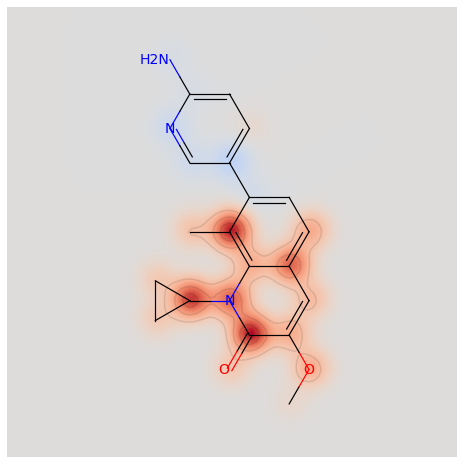

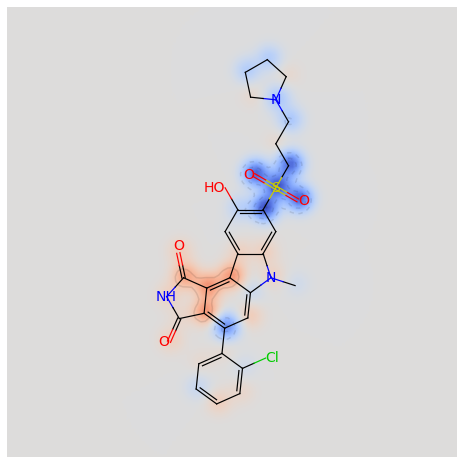

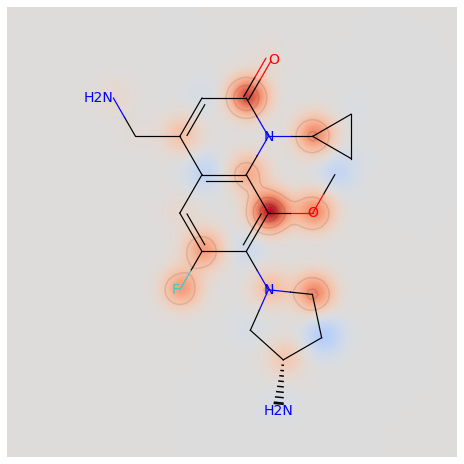

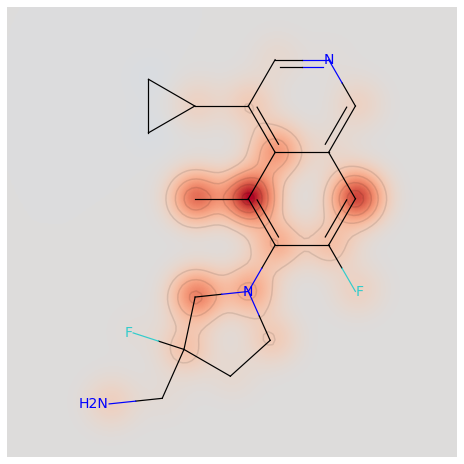

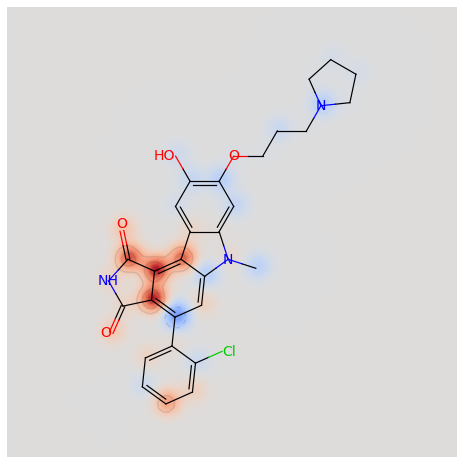

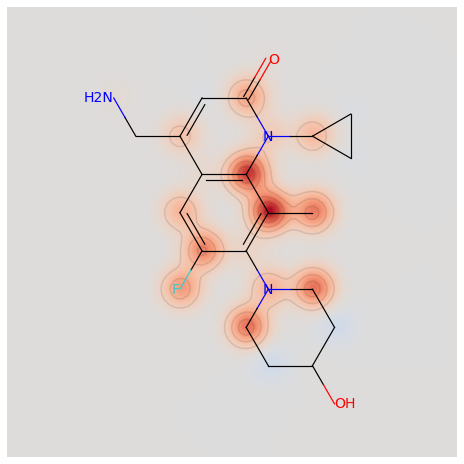

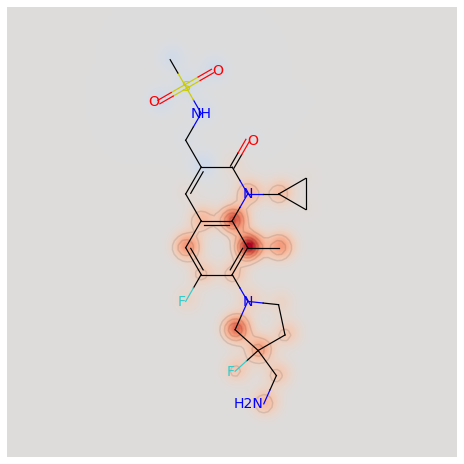

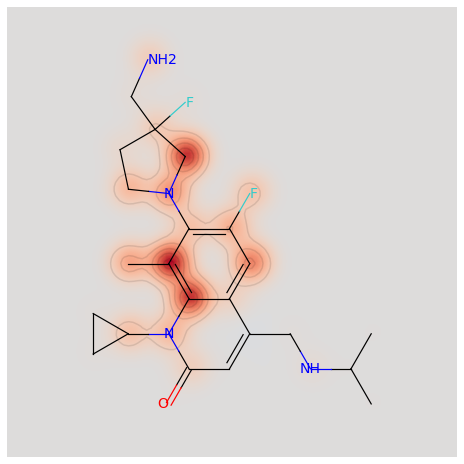

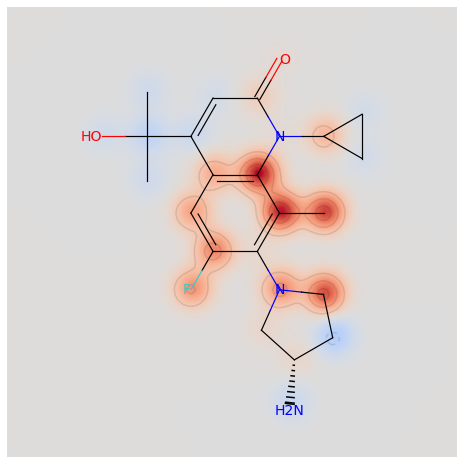

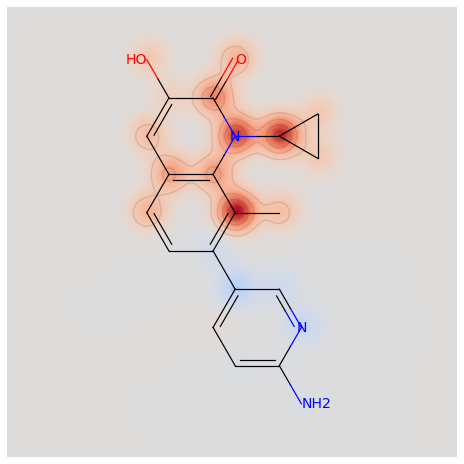

In [31]:
maps = vis_contribs(np.random.choice(np.array(mols),10), df)

In [32]:
def vis_contribs(mols, df, smi_or_sdf = "sdf"): 
    # input format of file, which was used to create dataset determines the order of atoms, 
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]
        if smi_or_sdf == "sdf":        
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt, colorMap="coolwarm",contourLines=5,alpha=0.1))
    return maps

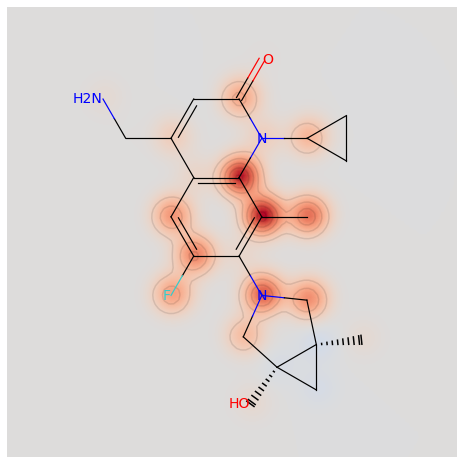

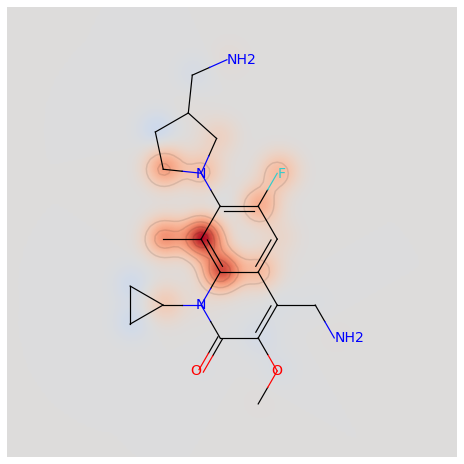

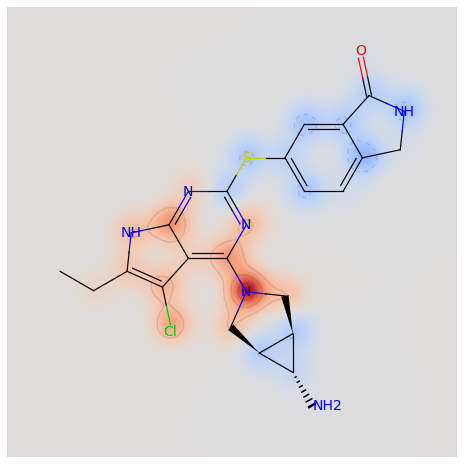

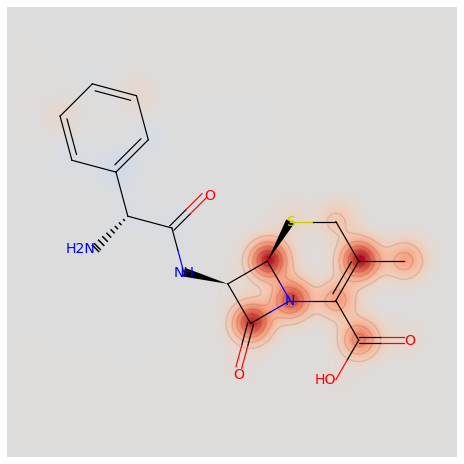

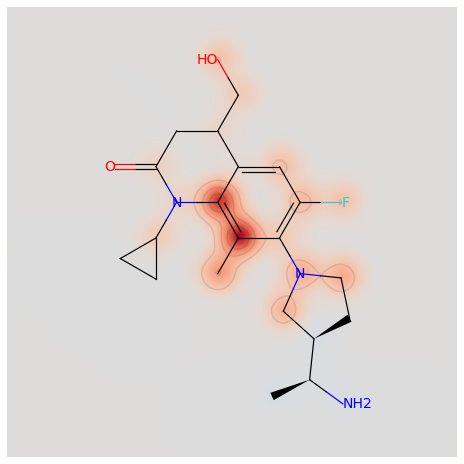

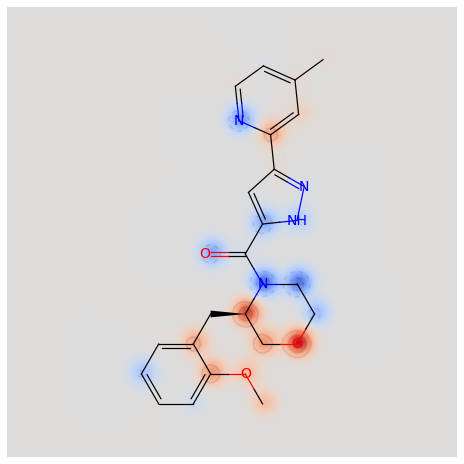

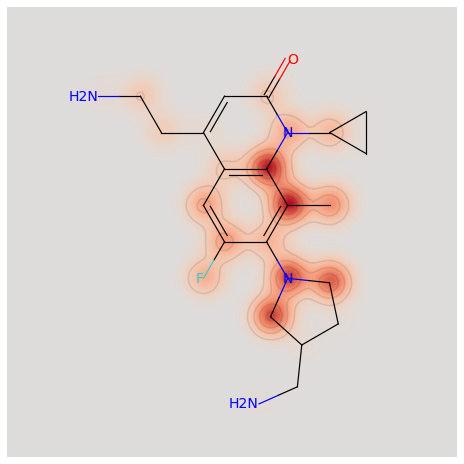

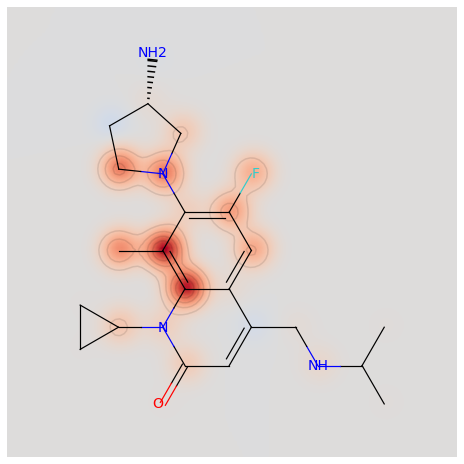

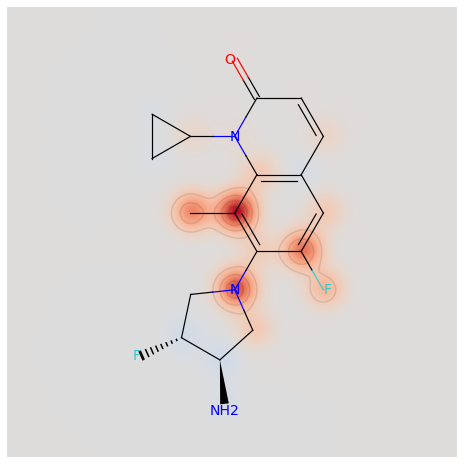

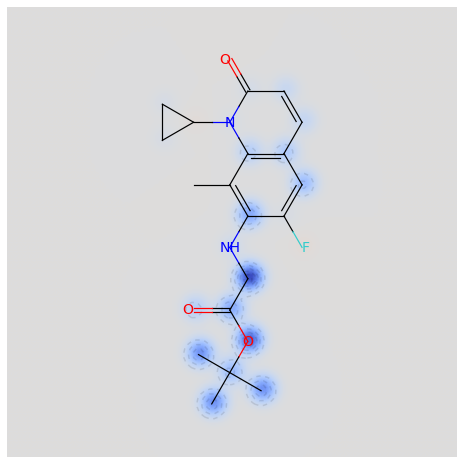

In [33]:
maps = vis_contribs(np.random.choice(np.array(mols),10), df)

Now looking at the fragment contribution for class 0 predictions.

Trying to establish which atoms cause a compound to be impermeable

In [34]:
# merge 2 dataframes by molecule names

# whole  molecules
pred = np.squeeze(model.predict(dataset))[:, 0] # probabilitiy of class 1
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convinience

# fragments
pred_frags = np.squeeze(model.predict(frag_dataset))[:, 0]
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]
np.random.seed(2000)


In [35]:
df.describe()

,Fragment,Molecule,Contrib
count,22102.000000,22102.000000,22102.000000
mean,0.237735,0.217867,-0.019868
std,0.211938,0.230395,0.152070
min,0.001836,0.002475,-0.789997
25%,0.065855,0.045698,-0.066155
50%,0.172082,0.112514,-0.003692
75%,0.349250,0.337081,0.030268
max,0.967457,0.957521,0.769088


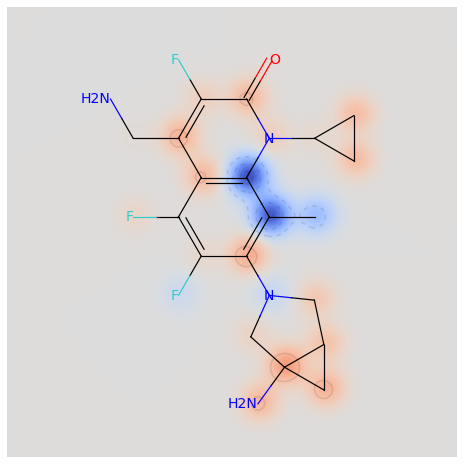

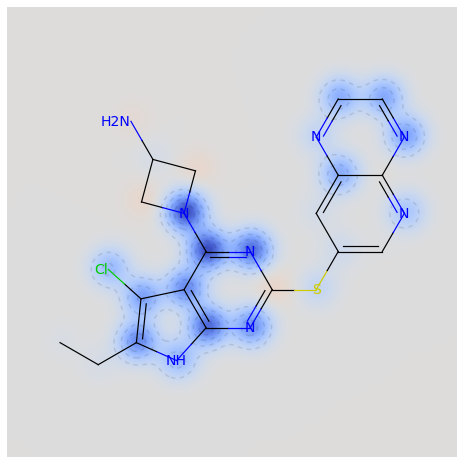

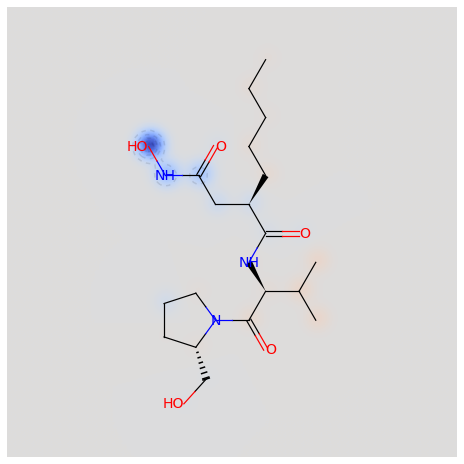

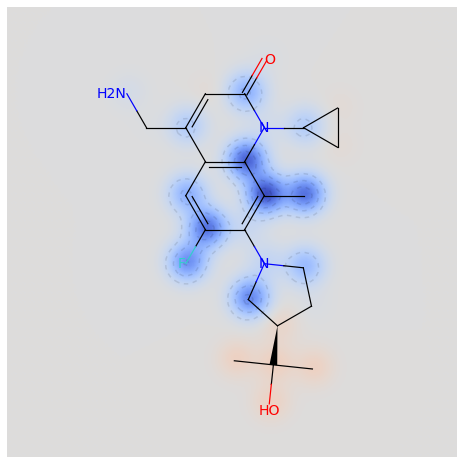

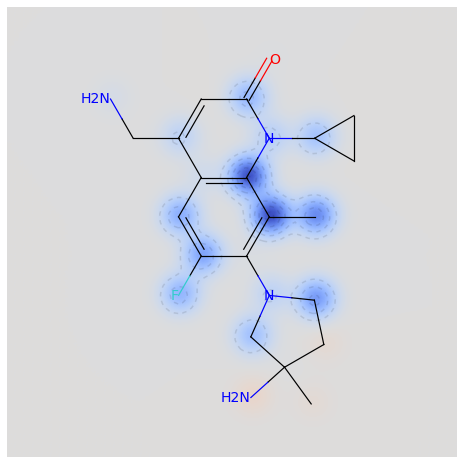

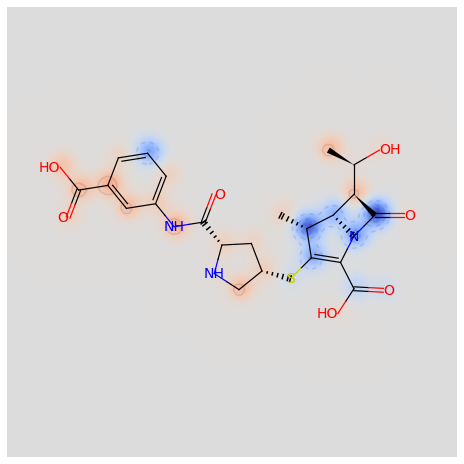

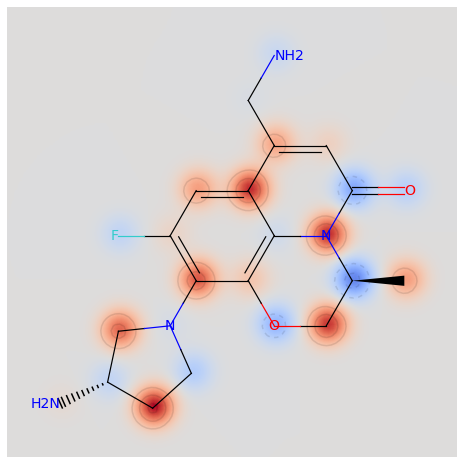

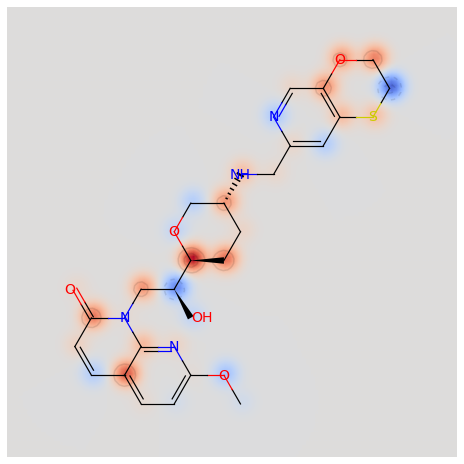

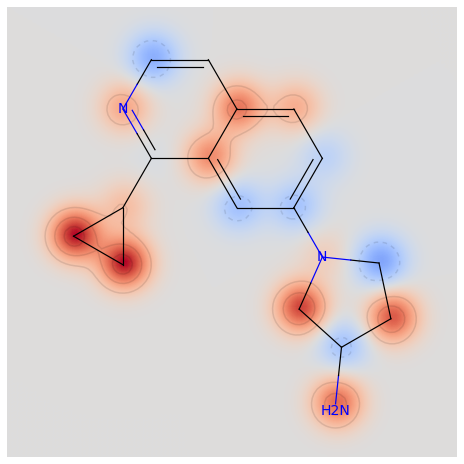

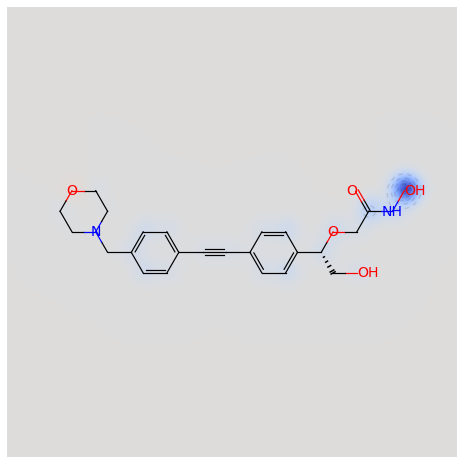

In [36]:
maps = vis_contribs(np.random.choice(np.array(mols),10), df)